# SCEPTR High-Weight TCR Analysis

In this notebook, we do the following:
1. Load a chosen SCEPTR model checkpoint (best epoch) from one run.
2. For each control and cancer patient, compute the attention weights for every TCR in that patient's repertoire.
3. Extract the top K TCRs by weight.
4. Count how frequently each TCR appears in top K among cancer vs control patients.

Finally, show tables that might reveal TCR sequences commonly flagged as "high weight" in multiple cancer patients.

In [88]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

from src.model import sceptr_unidirectional, load_trained
import sceptr

plt.rcParams["figure.figsize"] = (12, 8)
sns.set_style("whitegrid")

print("Imports done.")

Imports done.


## 1. Configuration
- Choose the run index and best epoch.
- Define paths to your `control` and `pbmc_cancer` directories.
- Define `TOP_K`.

In [89]:
# comment/uncomment either alpha or beta to use it

# sceptr alpha
# chain = "alpha"
# BEST_RUN_INDEX = 0
# BEST_EPOCH = 49
# CDR3 = 'CDR3A'

# sceptr beta
chain = "beta"
BEST_RUN_INDEX = 0
BEST_EPOCH = 33
CDR3 = 'CDR3B'

TOP_K = 100  # how many top TCRs to extract from each patient

base_dir = Path.cwd() / f"results-new-{chain}" / "sceptr"
model_dir = base_dir / f"trained-sceptr-{BEST_RUN_INDEX}" / f"Epoch {BEST_EPOCH}"
model_path = model_dir / f"classifier-{BEST_EPOCH}.pth"

# data dirs
eval_dir = Path.cwd() / "data" / chain / "sceptr-eval"
control_dir = eval_dir / "control"
cancer_dir = eval_dir / "pbmc_cancer"

print("Model path:", model_path)
print("Control dir:", control_dir)
print("Cancer dir:", cancer_dir)

Model path: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-0/Epoch 33/classifier-33.pth
Control dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/beta/sceptr-eval/control
Cancer dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/beta/sceptr-eval/pbmc_cancer


## 2. Load Model
Load the `sceptr_unidirectional` model with the chosen checkpoint.

In [90]:
model = load_trained(model_path, sceptr_unidirectional)
model.eval()
if torch.cuda.is_available():
    model.cuda()
print("Model loaded.")

Model loaded.


## 3. Helper: Get TCR Weights
Given a DataFrame of TCR sequences, runs them through the SCEPTR model to get the attention weights for each TCR.  Then, the top K can be identified.

In [91]:
import torch
import numpy as np

def get_tcr_weights_for_patient(df: pd.DataFrame, model: sceptr_unidirectional):
    # embeddings
    embeddings = sceptr.calc_vector_representations(df)
    embeddings_t = torch.tensor(embeddings, dtype=torch.float32)
    if torch.cuda.is_available():
        embeddings_t = embeddings_t.cuda()

    # forward pass
    with torch.no_grad():
        _ = model(embeddings_t)  # triggers model.last_weights
        weights = model.last_weights.detach().cpu().numpy().flatten()

    # 'CDR3A' for alpha chains, 'CDR3B' for the beta chains
    cdr3_col = CDR3
    if cdr3_col not in df.columns:
        cdr3_col = df.columns[0]

    out_df = df.copy()
    out_df['__weight__'] = weights
    out_df['__index__'] = range(len(out_df))
    return out_df

## 4. Process All Patients
Loop over `control/*.tsv` and `pbmc_cancer/*.tsv`.  For each file (patient):
1. Compute TCR weights.
2. Sort descending by weight.
3. Take the top K TCRs.
4. Collect them in a list.  Each record will have the TCR's sequence, weight, whether it’s from cancer or control, etc.


In [92]:
control_files = sorted(control_dir.glob("*.tsv"))
cancer_files = sorted(cancer_dir.glob("*.tsv"))

records = []  # { 'tcr': x, 'weight': y, 'label': 0/1, 'patient_id': ? }
cancer_weights = [] # store all weights for label 1 (cancer)

def process_patient_tcrs(file_path: Path, label: int, top_k=10):
    df = pd.read_csv(file_path, sep="\t")
    weights_df = get_tcr_weights_for_patient(df, model)

    # sort by weight descending
    weights_df = weights_df.sort_values(by="__weight__", ascending=False)
    top_df = weights_df.head(top_k)

    results = []
    for _, row in top_df.iterrows():
        # store cdr3 sequence, weight, label, patient
        rec = {
            'tcr': row.get(CDR3, 'unknown'),
            'weight': row['__weight__'],
            'label': label,
            'patient_id': file_path.stem
        }
        results.append(rec)
    
    for _, row in weights_df.iterrows():
        if label == 1:
            cancer_weights.append(row['__weight__'])

    return results

# Go through control and cancer patients
for f in tqdm(control_files):
    recs = process_patient_tcrs(f, label=0, top_k=TOP_K)
    records.extend(recs)

for f in tqdm(cancer_files):
    recs = process_patient_tcrs(f, label=1, top_k=TOP_K)
    records.extend(recs)


100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


In [93]:
df_top = pd.DataFrame(records)
print(f"Number of top TCR records = {len(df_top)}")

Number of top TCR records = 3300


## 5. Frequency Analysis
Given the DataFrame `df_top`, where each row is a TCR from the top K of some patient.  See how often each TCR appears in the top K for cancer vs control.

### 5.1 Groupby TCR
Groupby on `tcr` and `label` to see the counts.

In [94]:
grouped = df_top.groupby(["tcr", "label"]).size().reset_index(name="count")
grouped.head(15)

,tcr,label,count
0,CAAEPGQGTYEQYF,0,1
1,CAATAGTGDYEQYF,0,1
2,CAATEGRGSYEQYF,0,1
3,CACCLFGREQSGNTIYF,1,1
4,CACRERHCRGAGGYEQYF,1,1
5,CACSLGGASGHPGETQYF,1,1
6,CACSLMQGGSHEQYF,1,1
7,CAGAGLSETQYF,1,1
8,CAGETGANVLTF,0,1
9,CAGRPGKDSPLHF,0,1


### 5.2 Pivot into wide format
Pivot to get columns in format `[tcr, count_control, count_cancer]`.


In [95]:
pivoted = grouped.pivot(index="tcr", columns="label", values="count").fillna(0)
pivoted.columns = ["count_control", "count_cancer"]
pivoted = pivoted.sort_values(by="count_cancer", ascending=False)
pivoted.head(20)

,count_control,count_cancer
tcr,,
CASSHSGGLYEQYF,0.0,3.0
CASSYRLAGGPPILTQYF,0.0,3.0
CASRRGSGDETQYF,0.0,2.0
CASSYPPATGNSHLGEQYF,0.0,2.0
CASSSPPPGGGLGETQYF,0.0,2.0
CASSLDSAGGPWETQYF,0.0,2.0
CASLLGQGPYEQYF,0.0,2.0
CASSAGTGVTGELFF,0.0,2.0
CASSYFWGDQRDQYF,0.0,2.0


### 5.3 Display TCRs That Appear Frequently in Cancer But Not in Control
Only keep TCRs with `count_cancer >= X`.


In [96]:
min_cancer_count = 2
candidate_tcrs = pivoted[(pivoted["count_cancer"] >= min_cancer_count)]
print(f"Found {len(candidate_tcrs)} TCRs that appear >= {min_cancer_count} times in cancer.")
candidate_tcrs.head(20)

Found 29 TCRs that appear >= 2 times in cancer.


,count_control,count_cancer
tcr,,
CASSHSGGLYEQYF,0.0,3.0
CASSYRLAGGPPILTQYF,0.0,3.0
CASRRGSGDETQYF,0.0,2.0
CASSYPPATGNSHLGEQYF,0.0,2.0
CASSSPPPGGGLGETQYF,0.0,2.0
CASSLDSAGGPWETQYF,0.0,2.0
CASLLGQGPYEQYF,0.0,2.0
CASSAGTGVTGELFF,0.0,2.0
CASSYFWGDQRDQYF,0.0,2.0


In [97]:
import numpy as np
from scipy.stats import percentileofscore

filtered_cancer_weights = [w for w in cancer_weights if w > 0]

rows = []

for tcr in candidate_tcrs.index:
    matches = df_top[df_top['tcr'] == tcr]
    if matches.empty:
        continue

    for label in [0, 1]:
        label_matches = matches[matches['label'] == label]
        if not label_matches.empty:
            weights = sorted(label_matches['weight'].tolist())
            mean_weight = np.mean(weights)

            row = {
                'tcr': tcr,
                'label': label,
                'count_cancer': len(weights),
                'weights': weights,
                'mean_weight': mean_weight
            }

            # compute percentile only for label==1, else NaN
            if label == 1 and filtered_cancer_weights:
                row['mean_weight_percentile'] = percentileofscore(
                    filtered_cancer_weights, mean_weight, kind='rank'
                )
            else:
                row['mean_weight_percentile'] = np.nan

            rows.append(row)

# create DataFrame and sort by mean_weight descending
summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(by='mean_weight', ascending=False)

# display
pd.set_option('display.max_colwidth', None)
summary_df.head(20)


,tcr,label,count_cancer,weights,mean_weight,mean_weight_percentile
3,CASSYPPATGNSHLGEQYF,1,2,"[0.09754877537488937, 0.1027422770857811]",0.100146,99.597586
25,CASSYSVVEGRAPHEQYF,1,2,"[0.07691209018230438, 0.08286683261394501]",0.079889,98.189135
14,CASSEVRHRGPPNNEQFF,1,2,"[0.05472467839717865, 0.0615905299782753]",0.058158,93.158954
28,CASSLGMARGPRQDTQYF,1,2,"[0.049933061003685, 0.05679891258478165]",0.053366,90.342052
26,CASSESSREGRLDTQYF,1,2,"[0.036799356341362, 0.04366520792245865]",0.040232,85.110664
6,CASLLGQGPYEQYF,1,2,"[0.036821357905864716, 0.03859662264585495]",0.037709,82.494970
0,CASSHSGGLYEQYF,1,3,"[0.027124151587486267, 0.033990003168582916, 0.03873256593942642]",0.033282,77.867203
21,CASMSRGGTTPFSGNTIYF,1,2,"[0.022844895720481873, 0.031177327036857605]",0.027011,69.818913
10,CASSPMSGSHEQFF,1,2,"[0.022045351564884186, 0.030755527317523956]",0.026400,68.611670
18,CASSYSGTGLPLYEQYF,1,2,"[0.021163031458854675, 0.028028883039951324]",0.024596,65.995976


## 6. Additional Visualisations

- A bar chart of TCR frequencies in cancer vs control.
- A table listing the top 20 TCRs for each.

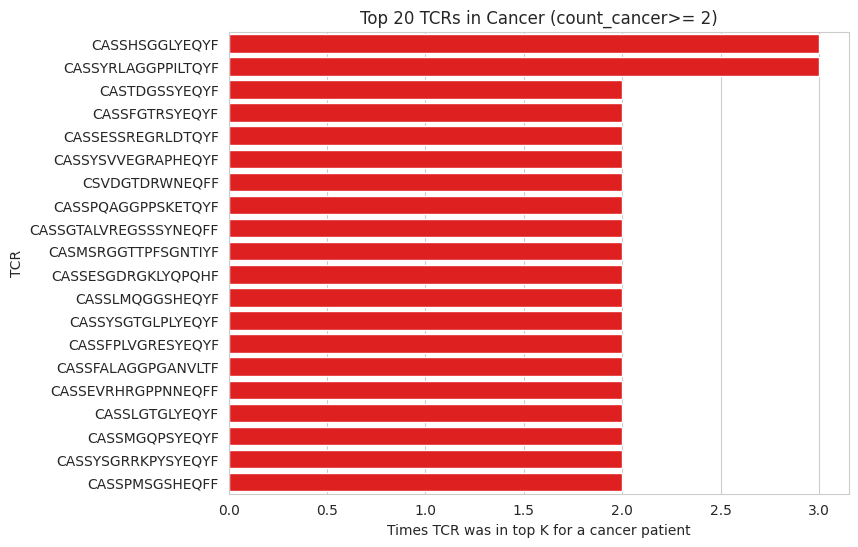

In [98]:
cand_sorted = candidate_tcrs.sort_values("count_cancer", ascending=False).head(20).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(
    data=cand_sorted,
    x="count_cancer",
    y="tcr",
    orient="h",
    color="red"
)
plt.title(f"Top 20 TCRs in Cancer (count_cancer>= {min_cancer_count})")
plt.xlabel("Times TCR was in top K for a cancer patient")
plt.ylabel("TCR")
plt.show()